# Evaluación de SVM en la clasificación de dibujos hechos a mano usando el conjunto de datos QuickDraw-10

- **Nombre:** Diego Valdés
- **Profesora:** Violeta Chang Camacho



## Objetivo de la tarea


Es evaluar el desempeño de SVM en la clasificación de imágenes de dibujos hechos a mano. El conjunto de datos utilizado es **QuickDraw-10**, que contiene 10 clases de imágenes hechas a mano, con un total de **9834 imágenes de entrenamiento** y **1166 imágenes de prueba**.

En este experimento se realizarán tres pruebas por cada modelo (RBC Y LINEAL), variando la estrategia de generación de vectores:
1. Los vectores son las imágenes directamente convertidas a vectores unificados de tamaño 256x256 (flatten).
2. Las imágenes se convierten a vectores de 256 dimensiones luego de aplicar PCA.
3. Las imágenes se convierten a vectores de 256 dimensiones luego de aplicar UMAP.


In [1]:
# Importar las librerías necesarias para el proyecto
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import GridSearchCV
import umap
from tqdm import tqdm
import time




## Extracción de los datos
Se verifica que la carpeta contiene las siguientes carpetas y archivos:

* mapping.txt: Mapea las etiquetas a las clases.

* train.txt: Contiene las rutas a las imágenes de entrenamiento y sus respectivas etiquetas.

* test.txt: Contiene las rutas a las imágenes de prueba y sus respectivas etiquetas.

* images/: Carpeta con las imágenes de todos los dibujos.

In [2]:
# Ruta del archivo descomprimido
ruta_base = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea 1\\QuickDraw-10"

print("Archivos dentro de QuickDraw-10:")
archivos = os.listdir(ruta_base)

# Imprimir la lista de archivos
for archivo in archivos:
    print(archivo)


Archivos dentro de QuickDraw-10:
images
mapping.txt
test.txt
train.txt
train_40.txt


# Carga y estructura de los datos

Cada imagen es convertida a una matriz NumPy de 256x256 elementos, donde cada valor representa la intensidad de un píxel (0 a 255). Como resultado:

* X_train.shape = (9834, 256, 256): contiene 9834 imágenes de entrenamiento.

* y_train.shape = (9834,): etiquetas correspondientes a X_train, con valores entre 0 y 9 (una por clase).

* X_test.shape = (1166, 256, 256): contiene 1166 imágenes de prueba.

* y_test.shape = (1166,): etiquetas correspondientes a X_test.

In [3]:
# Tamaño de la imagen
IMG_SIZE = 256

def cargartxt(txt_path, base_dir):
    X = []
    y = []
    with open(txt_path, 'r') as f:
        lineas = f.readlines()
        for linea in tqdm(lineas, desc=f"Cargando {os.path.basename(txt_path)}"):
            ruta_rel, etiqueta = linea.strip().split()
            ruta_img = os.path.join(base_dir, ruta_rel)
            try:
                img = Image.open(ruta_img).convert("L").resize((IMG_SIZE, IMG_SIZE))
                X.append(np.array(img))
                y.append(int(etiqueta))
            except Exception as e:
                print(f"Error al leer {ruta_img}: {e}")
    return np.array(X), np.array(y)

# Ruta base de imágenes y archivos txt
BASE_DIR ="C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea 1\\QuickDraw-10"
X_train, y_train = cargartxt(os.path.join(BASE_DIR, "train_40.txt"), BASE_DIR)
X_test, y_test = cargartxt(os.path.join(BASE_DIR, "test.txt"), BASE_DIR)

# Mostrar tamaños
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Cargando test.txt: 100%|██████████| 1166/1166 [00:01<00:00, 605.50it/s]


X_train: (3930, 256, 256) y_train: (3930,)
X_test: (1166, 256, 256) y_test: (1166,)


# Visualización de las imágenes



Para corroborar que las imágenes estan cargando correctamente se escogeran algunas y se mostrarán.

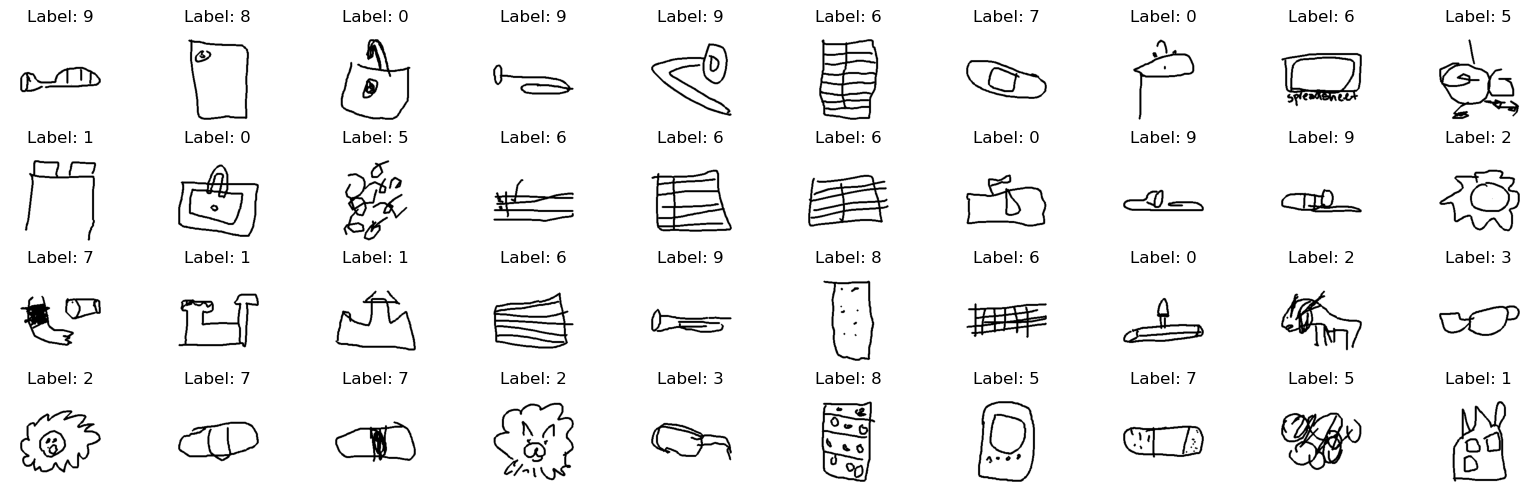

In [4]:

# Imágenes de train

# Seleccionar 40 índices aleatorios
random = np.random.choice(len(X_train), size=50, replace=False)

imagenes_random = [X_train[i].reshape(256, 256) for i in random]
labels_random = [y_train[i] for i in random]

fig, axes = plt.subplots(4, 10, figsize=(20, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(imagenes_random[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {labels_random[i]}')
plt.show()


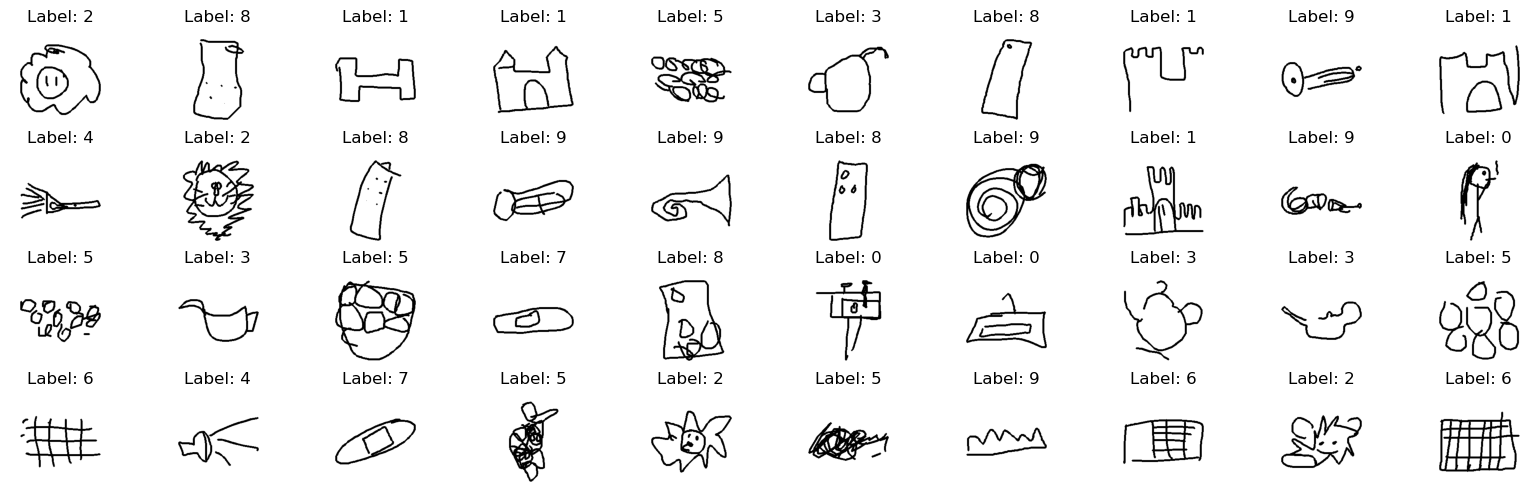

In [31]:
# Imágenes de test

# Seleccionar 40 índices aleatorios
random = np.random.choice(len(X_test), size=50, replace=False)

imagenes_random = [X_test[i].reshape(256, 256) for i in random]
labels_random = [y_test[i] for i in random]

fig, axes = plt.subplots(4, 10, figsize=(20, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(imagenes_random[i], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {labels_random[i]}')
plt.show()

## Mapeo de las imágenes


In [32]:
# Ruta del archivo mapping.txt
path = "C:\\Users\\diego\\OneDrive\\Escritorio\\Tarea 1\\QuickDraw-10\\mapping.txt"

with open(path, 'r') as archivo:
    lineas = archivo.readlines()

# Mostrar las primeras líneas para verificar el contenido
for linea in lineas:
    print(linea.strip())


sink	0
castle	1
lion	2
teapot	3
flashlight	4
blackberry	5
spreadsheet	6
bandage	7
remote-control	8
trombone	9


## Selección para Entrenamiento y Prueba

Se realizará la selección aleatoria de 400 imágenes de entrenamiento y 100 imágenes de prueba para cada una de las 10 clases del conjunto QuickDraw-10. El objetivo es asegurar que los conjuntos de entrenamiento y prueba estén bien balanceados y no colapsar mi máquina.

Se establece una semilla aleatoria con valor 42.

In [5]:
# Establecer la semilla aleatoria para reproducibilidad
np.random.seed(42)

# Número de muestras por clase para entrenamiento y prueba
clases_train = 400
clases_test = 100

# Se inicializan listas para almacenar los índices de entrenamiento y prueba
train_index = []
test_index = []

for label in range(10):  

    train_index_label = np.where(y_train == label)[0]  
    test_index_label = np.where(y_test == label)[0]    

    # Se asegura que los índices están desordenados
    np.random.shuffle(train_index_label)
    np.random.shuffle(test_index_label)

    # Se separan los índices para entrenamiento y prueba de forma secuencial para evitar mezclar
    train_i = train_index_label[:clases_train]
    test_i = test_index_label[:clases_test]

    # Se agregan los índices a las listas correspondientes
    train_index.extend(train_i)
    test_index.extend(test_i)

# Se usan los índices para obtener las imágenes y etiquetas finales de entrenamiento y prueba
final_train_images = X_train[train_index, :]
final_train_labels = y_train[train_index]
final_test_images = X_test[test_index, :]
final_test_labels = y_test[test_index]

# Se comprueba que se obtuvo la cantidad de muestras solicitadas
print("Train images shape:", final_train_images.shape)
print("Train labels shape:", final_train_labels.shape)
print("Test images shape:", final_test_images.shape)
print("Test labels shape:", final_test_labels.shape)



Train images shape: (3930, 256, 256)
Train labels shape: (3930,)
Test images shape: (1000, 256, 256)
Test labels shape: (1000,)


## Aplanar imágenes

In [6]:
# Verificar si los arrays de imágenes tienen datos
print("final_train_images shape:", final_train_images.shape)
print("final_test_images shape:", final_test_images.shape)

# Verificar si las imágenes se cargaron correctamente
if final_train_images.shape[0] == 0 or final_test_images.shape[0] == 0:
    print("Error: No se cargaron imágenes correctamente.")
else:
    # Aplanar las imágenes solo si los datos están presentes
    final_train_images_flat = final_train_images.reshape(final_train_images.shape[0], -1)
    final_test_images_flat = final_test_images.reshape(final_test_images.shape[0], -1)
    print("Imágenes aplanadas correctamente.")


final_train_images shape: (3930, 256, 256)
final_test_images shape: (1000, 256, 256)
Imágenes aplanadas correctamente.


## Imágenes aplanadas con PCA

In [7]:

# Aplicar PCA para reducir a 256 componentes
pca = PCA(n_components=256)  
final_train_images_pca = pca.fit_transform(final_train_images_flat)  
final_test_images_pca = pca.transform(final_test_images_flat)  

# Verificar las dimensiones después de PCA
print("Shape de final_train_images_pca:", final_train_images_pca.shape)  
print("Shape de final_test_images_pca:", final_test_images_pca.shape) 


Shape de final_train_images_pca: (3930, 256)
Shape de final_test_images_pca: (1000, 256)


## Imágenes aplanadas con UMAP

In [9]:
# Aplicar UMAP para reducir a 256 componentes
umap_model = umap.UMAP(n_components=256) 
final_train_images_umap = umap_model.fit_transform(final_train_images_flat) 
final_test_images_umap = umap_model.transform(final_test_images_flat)  

# Verificar las dimensiones después de UMAP
print("Shape de final_train_images_umap:", final_train_images_umap.shape)  
print("Shape de final_test_images_umap:", final_test_images_umap.shape) 

Shape de final_train_images_umap: (3930, 256)
Shape de final_test_images_umap: (1000, 256)


## Función de matriz de confusión

In [10]:
def matriz(y_true, y_pred, labels=None):
    
    cm = confusion_matrix(y_true, y_pred, labels=labels) 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues')
    plt.title("Matriz de Confusión")
    plt.show()


## Función train y evaluate

Para poder medir el tiempo que se demora en entrenar el modelo y cuanto se demora en evaluarse

In [11]:
# Función para entrenar el modelo
def train_model(pipeline, X_train, y_train):
    start_time = time.time() 

    # Entrenar el modelo
    pipeline.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"Tiempo de entrenamiento: {end_time - start_time:.2f} segundos")
    
    return pipeline

# Función para evaluar el modelo
def evaluate_model(pipeline, X_test, y_test):

    start_time = time.time() 

    # Hacer las predicciones
    test_predictions = pipeline.predict(X_test)

    end_time = time.time()
    print(f"Tiempo de testeo: {end_time - start_time:.2f} segundos")
    # Calcular la precisión total
    accuracy = accuracy_score(y_test, test_predictions)
    print(f"Accuracy total de la SVM: {accuracy}")
    
    # Obtener el reporte de clasificación
    report = classification_report(y_test, test_predictions)
    print("Reporte de Clasificación (Métricas de todas las clases):")
    print(report)
    
    return accuracy, test_predictions

## Búsqueda de mejor hiperparámetro C

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def ajustar_C(modelo,X_entrenamiento, y_entrenamiento):
    # Rango de valores de C para probar
    rango_C = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0] 
    
    # Definir los parámetros para GridSearchCV
    parametros = [{
        'svm__C': rango_C, 
    }]
    
    # Crear el modelo SVM con kernel RBF
    modelo_svm = SVC(kernel=modelo)
    
    # Crear el pipeline que incluye StandardScaler y SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  
        ('svm', modelo_svm) 
    ])
    
    # Configurar GridSearchCV con validación cruzada de 5 pliegues
    busqueda = GridSearchCV(estimator=pipeline, param_grid=parametros, scoring='accuracy', cv=5, n_jobs=-1)  # Usamos el pipeline
    
    # Ajustar el modelo con los datos de entrenamiento
    busqueda.fit(X_entrenamiento, y_entrenamiento)
    
    # Mostrar los mejores parámetros y la mejor precisión obtenida
    print("Mejor precisión:", busqueda.best_score_)
    print("Mejores parámetros:", busqueda.best_params_)

    return busqueda.best_params_, busqueda.best_score_



## PARTE 1 RBF : Experimento N°1

En este experimento se debe trabajar con las imágenes aplanadas teniendo que convertir cada imagen de 256x256 píxeles a un vector unidimensional.


In [ ]:
mejores_parametros1_1, mejor_precision = ajustar_C('rbf',final_train_images_flat, final_train_labels)

Mejor precisión: 0.562
Mejores parámetros: {'svm__C': 10.0}


In [20]:
# Usar mejor C pero ahora con más datos.

# Crear el pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='rbf',C=10.0)) 
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_flat, final_train_labels)

# Evaluar el modelo
accuracy1_1, prediccion1_1 = evaluate_model(svm_pipeline, final_test_images_flat, final_test_labels)


Tiempo de entrenamiento: 598.11 segundos
Tiempo de testeo: 295.28 segundos
Accuracy total de la SVM: 0.676
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       0.71      0.67      0.69       100
           1       0.60      0.65      0.62       100
           2       0.73      0.55      0.63       100
           3       0.75      0.78      0.76       100
           4       0.61      0.69      0.65       100
           5       0.66      0.67      0.66       100
           6       0.66      0.76      0.70       100
           7       0.72      0.64      0.68       100
           8       0.76      0.79      0.77       100
           9       0.60      0.56      0.58       100

    accuracy                           0.68      1000
   macro avg       0.68      0.68      0.67      1000
weighted avg       0.68      0.68      0.67      1000



## 1.1.1 Matriz de confusión

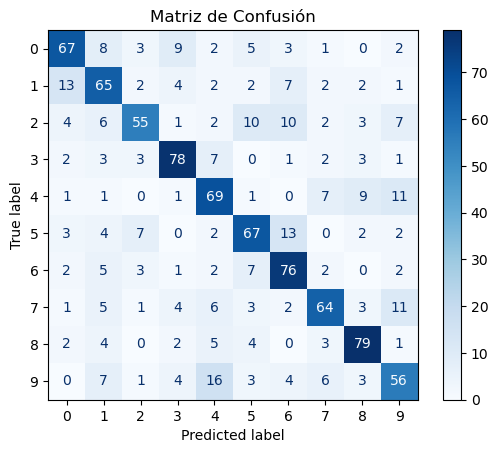

In [21]:
matriz(final_test_labels, prediccion1_1, labels=np.unique(final_test_labels))

## PARTE 1 RBF : Experimento N°2

los vectores son directamente las imágenes convertidas a vectores de 256 elementos, luego de aplicar PCA.


In [ ]:
mejores_parametros1_2, mejor_precision = ajustar_C('rbf',final_train_images_pca, final_train_labels)

Mejor precisión: 0.6091603053435114
Mejores parámetros: {'svm__C': 10.0}


In [26]:
# Crear el pipeline con SVM 
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svm', SVC(kernel='rbf',C=10.0))  
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_pca, final_train_labels)

# Evaluar el modelo
accuracy1_2, prediccion1_2 = evaluate_model(svm_pipeline, final_test_images_pca, final_test_labels)

Tiempo de entrenamiento: 3.64 segundos
Tiempo de testeo: 1.44 segundos
Accuracy total de la SVM: 0.617
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       100
           1       0.57      0.69      0.63       100
           2       0.55      0.36      0.44       100
           3       0.61      0.76      0.68       100
           4       0.52      0.83      0.64       100
           5       0.62      0.45      0.52       100
           6       0.82      0.53      0.64       100
           7       0.61      0.70      0.65       100
           8       0.64      0.78      0.71       100
           9       0.64      0.47      0.54       100

    accuracy                           0.62      1000
   macro avg       0.63      0.62      0.61      1000
weighted avg       0.63      0.62      0.61      1000



## 1.2.1 Matriz de confusión

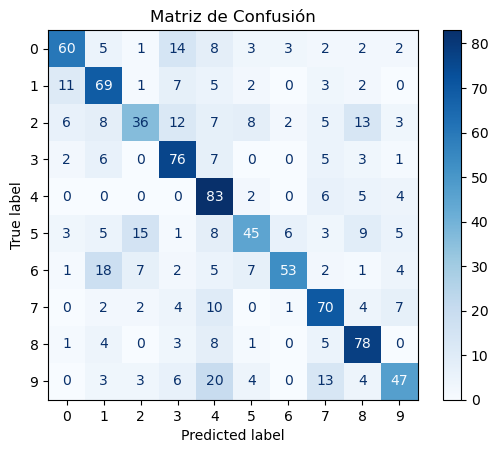

In [27]:
matriz(final_test_labels,prediccion1_2, labels=np.unique(final_test_labels))

## Parte 1: RBF Experimento 3

los vectores son directamente las imágenes convertidas a vectores de 256 elementos, luego de aplicar UMAP.


In [28]:
mejores_parametros1_3, mejor_precision = ajustar_C('rbf',final_train_images_umap, final_train_labels)

Mejor precisión: 0.7603053435114504
Mejores parámetros: {'svm__C': 10.0}


In [46]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svm', SVC(kernel='rbf',C=10.0)) 
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_umap, final_train_labels)

# Evaluar el modelo
accuracy1_3, prediccion1_3 = evaluate_model(svm_pipeline, final_test_images_umap, final_test_labels)

Tiempo de entrenamiento: 0.66 segundos
Tiempo de testeo: 0.49 segundos
Accuracy total de la SVM: 0.267
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       100
           1       0.22      0.02      0.04       100
           2       0.14      0.01      0.02       100
           3       0.29      0.30      0.29       100
           4       0.25      0.21      0.23       100
           5       0.12      0.57      0.20       100
           6       0.32      0.09      0.14       100
           7       0.43      0.50      0.47       100
           8       0.53      0.61      0.56       100
           9       0.46      0.33      0.39       100

    accuracy                           0.27      1000
   macro avg       0.38      0.27      0.24      1000
weighted avg       0.38      0.27      0.24      1000



## 1.3.1 Matriz de confusión 


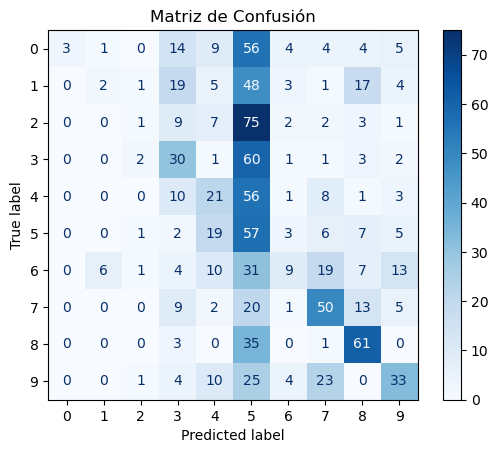

In [15]:
matriz(final_test_labels, prediccion1_3, labels=np.unique(final_test_labels))

## PARTE 2: Experimento N°1

usar un kernel distinto a RBF y valores de demás hiperparámetros a decisión personal -> Usaré Lineal



In [ ]:
mejores_parametros2_1, mejor_precision = ajustar_C('linear',final_train_images_flat, final_train_labels)

Mejor precisión: 0.524
Mejores parámetros: {'svm__C': 0.01}


In [37]:
# Crear el pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('svm', SVC(kernel='linear',C=0.01)) 
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_flat, final_train_labels)

# Evaluar el modelo
accuracy2_1, prediccion2_1 = evaluate_model(svm_pipeline, final_test_images_flat, final_test_labels)

Tiempo de entrenamiento: 525.01 segundos
Tiempo de testeo: 73.75 segundos
Accuracy total de la SVM: 0.592
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       0.58      0.66      0.62       100
           1       0.55      0.65      0.60       100
           2       0.60      0.44      0.51       100
           3       0.69      0.70      0.70       100
           4       0.48      0.58      0.52       100
           5       0.63      0.55      0.59       100
           6       0.62      0.54      0.58       100
           7       0.60      0.60      0.60       100
           8       0.67      0.72      0.70       100
           9       0.52      0.48      0.50       100

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.59      1000
weighted avg       0.60      0.59      0.59      1000



## 2.1.1 Matriz de confusión

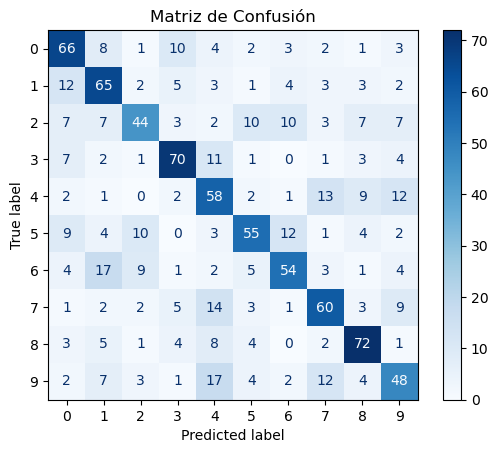

In [38]:
matriz(final_test_labels, prediccion2_1, labels=np.unique(final_test_labels))

## PARTE 2: Experimento N°2 PCA

In [30]:
mejores_parametros2_2, mejor_precision = ajustar_C('linear',final_train_images_pca, final_train_labels)

Mejor precisión: 0.5363867684478372
Mejores parámetros: {'svm__C': 0.01}


In [31]:
# Crear el pipeline con SVM 
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svm', SVC(kernel='linear',C=0.01))  
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_pca, final_train_labels)

# Evaluar el modelo
accuracy2_2, prediccion2_2 = evaluate_model(svm_pipeline, final_test_images_pca, final_test_labels)

Tiempo de entrenamiento: 2.24 segundos
Tiempo de testeo: 0.80 segundos
Accuracy total de la SVM: 0.595
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       100
           1       0.53      0.59      0.56       100
           2       0.64      0.59      0.61       100
           3       0.64      0.65      0.64       100
           4       0.46      0.64      0.54       100
           5       0.65      0.55      0.59       100
           6       0.71      0.60      0.65       100
           7       0.62      0.63      0.62       100
           8       0.70      0.67      0.68       100
           9       0.46      0.39      0.42       100

    accuracy                           0.59      1000
   macro avg       0.60      0.59      0.60      1000
weighted avg       0.60      0.59      0.60      1000



## 2.2.1 Matriz de confusión

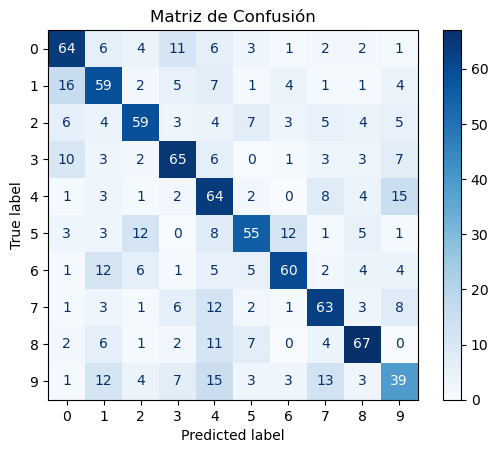

In [32]:
matriz(final_test_labels, prediccion2_2, labels=np.unique(final_test_labels))

## PARTE 2: Experimento N°3 UMAP

In [33]:
mejores_parametros2_3, mejor_precision = ajustar_C('linear',final_train_images_umap, final_train_labels)


Mejor precisión: 0.7412213740458016
Mejores parámetros: {'svm__C': 10.0}


In [34]:
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('svm', SVC(kernel='linear',C=10.0)) 
])

# Entrenar el modelo
svm_pipeline = train_model(svm_pipeline, final_train_images_umap, final_train_labels)

# Evaluar el modelo
accuracy2_3, prediccion2_3 = evaluate_model(svm_pipeline, final_test_images_umap, final_test_labels)

Tiempo de entrenamiento: 6.72 segundos
Tiempo de testeo: 0.12 segundos
Accuracy total de la SVM: 0.304
Reporte de Clasificación (Métricas de todas las clases):
              precision    recall  f1-score   support

           0       0.15      0.65      0.24       100
           1       0.33      0.06      0.10       100
           2       0.21      0.35      0.26       100
           3       0.33      0.03      0.06       100
           4       0.22      0.14      0.17       100
           5       0.78      0.31      0.44       100
           6       0.52      0.12      0.20       100
           7       0.55      0.48      0.51       100
           8       0.75      0.54      0.63       100
           9       0.47      0.36      0.41       100

    accuracy                           0.30      1000
   macro avg       0.43      0.30      0.30      1000
weighted avg       0.43      0.30      0.30      1000



## 2.3.1 Matriz de confusión

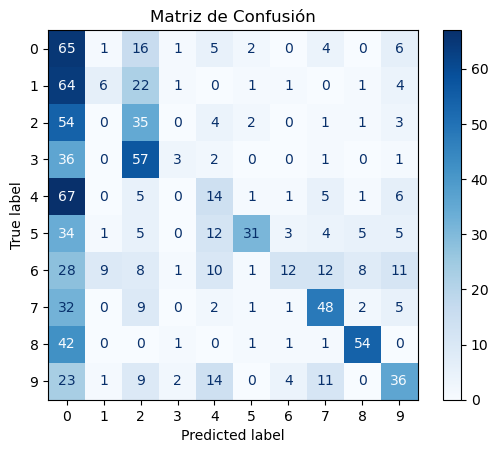

In [35]:
matriz(final_test_labels, prediccion2_3, labels=np.unique(final_test_labels))

## Acurracy por modelo

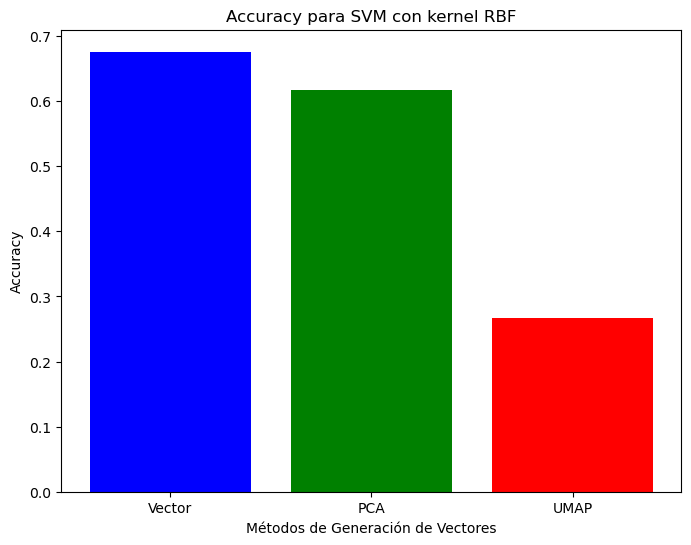

In [36]:

# Valores de accuracy para RBF
accuracy_rbf = [accuracy1_1, accuracy1_2, accuracy1_3]

# Nombres para el gráfico y etiquetas específicas
labels_rbf = ['Vector', 'PCA', 'UMAP']

# Colores para cada barra
colors_rbf = ['blue', 'green', 'red']  

# Crear el gráfico de barras para RBF
plt.figure(figsize=(8, 6))
plt.bar(labels_rbf, accuracy_rbf, color=colors_rbf)  

# Añadir títulos y etiquetas
plt.title('Accuracy para SVM con kernel RBF')
plt.xlabel('Métodos de Generación de Vectores')
plt.ylabel('Accuracy')

# Mostrar el gráfico
plt.show()



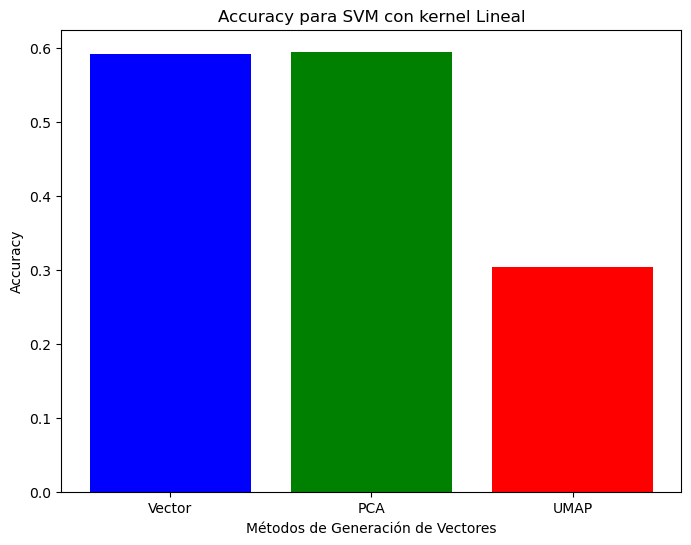

In [39]:
# Valores de accuracy para SVM con kernel Lineal
accuracy_linear = [accuracy2_1, accuracy2_2, accuracy2_3]

# Nombres para el gráfico y etiquetas específicas
labels_linear = ['Vector', 'PCA', 'UMAP']

# Colores para cada barra
colors_linear = ['blue', 'green', 'red']  # Puedes elegir los colores que prefieras

# Crear el gráfico de barras para Lineal
plt.figure(figsize=(8, 6))
plt.bar(labels_linear, accuracy_linear, color=colors_linear)  # Asignar colores a cada barra

# Añadir títulos y etiquetas
plt.title('Accuracy para SVM con kernel Lineal')
plt.xlabel('Métodos de Generación de Vectores')
plt.ylabel('Accuracy')

# Mostrar el gráfico
plt.show()



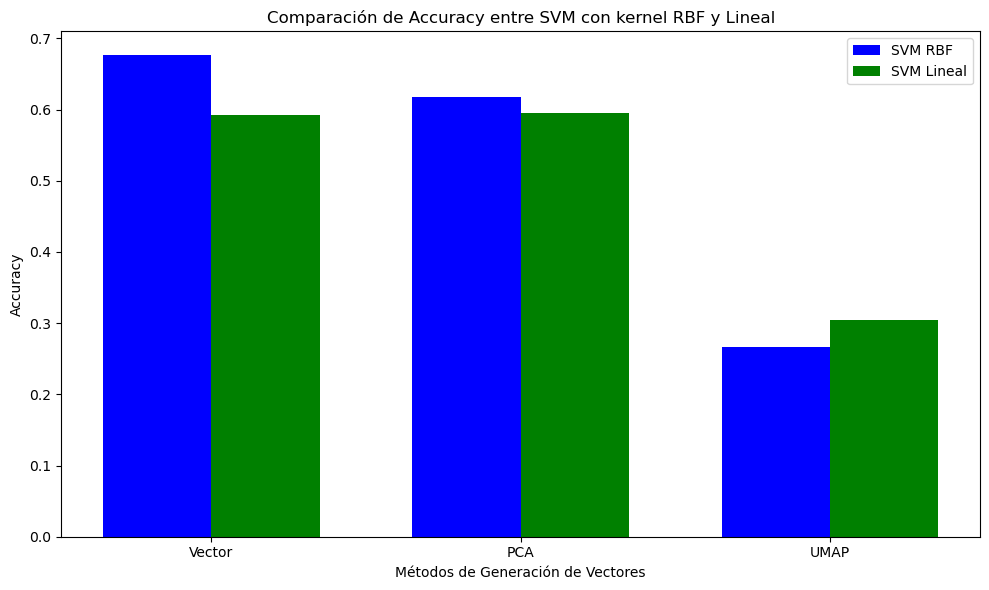

In [40]:
# Valores de accuracy para RBF y Lineal
accuracy_rbf = [accuracy1_1, accuracy1_2, accuracy1_3]
accuracy_linear = [accuracy2_1, accuracy2_2, accuracy2_3]

# Nombres para el gráfico y etiquetas específicas
labels = ['Vector', 'PCA', 'UMAP']

# Colores para las barras de RBF y Lineal
colors_rbf = 'blue'
colors_linear = 'green'

# Ancho de las barras
bar_width = 0.35

# Ubicación de las barras en el eje X
index = np.arange(len(labels))

# Crear el gráfico de barras agrupadas
plt.figure(figsize=(10, 6))
plt.bar(index, accuracy_rbf, bar_width, label='SVM RBF', color=colors_rbf)
plt.bar(index + bar_width, accuracy_linear, bar_width, label='SVM Lineal', color=colors_linear)

# Añadir títulos y etiquetas
plt.title('Comparación de Accuracy entre SVM con kernel RBF y Lineal')
plt.xlabel('Métodos de Generación de Vectores')
plt.ylabel('Accuracy')
plt.xticks(index + bar_width / 2, labels) 
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()
